In [1]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
### Create new output files with the hurricane at the center of the domain ####
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [2]:
#%% Define file locations
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01/"
WRF_DIRECTORY = "/projects/misa5952/simulations/hurricanes/newSetup/sst_30_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY = "/projects/misa5952/simulations/hurricanes/newSetup/sst_28_skipd01_skipCoLES_ndg/"


domain = 'd01'
fName = 'wrfrst'
notThis = ['mod','init']

# Vertical level to get max wind speed
i_z_max = 0

# Time to get axisymmetric BC
if 'sst_26' in WRF_DIRECTORY:
    axisymmTime_0 = np.datetime64('2000-01-05T00:00:00')
    axisymmTime_1 = np.datetime64('2000-01-06T00:00:00')
elif 'sst_30' in WRF_DIRECTORY:
    axisymmTime_0 = np.datetime64('2000-01-05T00:00:00')
    axisymmTime_1 = np.datetime64('2000-01-06T00:00:00')
elif 'sst_28' in WRF_DIRECTORY:
    axisymmTime_0 = np.datetime64('2000-01-04T10:00:00')
    axisymmTime_1 = np.datetime64('2000-01-05T10:00:20')

In [3]:
#%% Extract data from 3D fields
# Find auxHist files for current domain within directory
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    # Check if domain matches
    if domain in entries[i]:
        # Check if it is an auxHist file
        if fName in entries[i]:
            if not(notThis[0] in entries[i]):
                if not(notThis[1] in entries[i]):
                    # Check if time matches
                    ds = xr.open_dataset(WRF_DIRECTORY+entries[i],decode_times=False)
                    time_temp = np.array(ds['Times'])
                    ds.close()
                    ttime = np.array(['2000-01-01T00:00:00'], dtype='datetime64')
                    a = str(time_temp)
                    ttime = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
                    if (ttime>axisymmTime_0) & (ttime<axisymmTime_1):
                        ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)


# Extract and save data from each restart file
for i_f in np.arange(0,len(ofInterest),1):
    # Open file
    ds = xr.open_dataset(WRF_DIRECTORY+str(entries[ofInterest[i_f]]),decode_times=False)
    # Extract data
    u_temp = np.array(ds['U_1'])
    v_temp = np.array(ds['V_1'])
    w_temp = np.array(ds['W_1'])
    t_temp = np.array(ds['T'])
    thm_temp = np.array(ds['THM_1'])
    qv_temp = np.array(ds['QVAPOR'])
    time_temp = np.array(ds['Times'])
    # De-stagger variables
    u_temp = 0.5*(u_temp[:,:,:,0:np.shape(u_temp)[3]-1]+u_temp[:,:,:,1:np.shape(u_temp)[3]])
    v_temp = 0.5*(v_temp[:,:,0:np.shape(v_temp)[2]-1,:]+v_temp[:,:,1:np.shape(v_temp)[2],:])
    w_temp = 0.5*(w_temp[:,0:np.shape(w_temp)[1]-1,:,:]+w_temp[:,1:np.shape(w_temp)[1],:,:])
    uv_temp = (u_temp**2 + v_temp**2)**0.5
    # Save variables
    if i_f==0:
        # Height variables
        ph = ds['PH_1']
        ph = np.array(ph[0,:,:,:])
        ph = np.mean(np.mean(ph,axis=1),axis=1)
        phb = ds['PHB']
        phb = np.array(phb[0,:,:,:])
        phb = np.mean(np.mean(phb,axis=1),axis=1)
        height_stag = (ph+phb)/9.81
        height_agl = 0.5*(height_stag[1:] + height_stag[0:-1])
        # Create new variables
        u = np.zeros_like(u_temp) + u_temp
        v = np.zeros_like(v_temp) + v_temp
        w = np.zeros_like(w_temp) + w_temp
        theta = np.zeros_like(t_temp) + t_temp
        thm = np.zeros_like(thm_temp) + thm_temp
        qv = np.zeros_like(qv_temp) + qv_temp
        uv = np.zeros_like(uv_temp) + uv_temp
        Time = []
        Time.append(time_temp)
        # Domain dimensions
        dx = ds.DX
        n_x = dx*np.arange(0,np.shape(uv)[3])
        n_y = dx*np.arange(0,np.shape(uv)[2])
        # Free-up memory
        ph = 0.0
        phb = 0.0
        height_stag = 0.0
        # Base-state variables
        base_t = np.array(ds['T_BASE'])
        base_qv = np.array(ds['QV_BASE'])
    else:
        # Append data to saved variables
        u = np.append(u,u_temp,axis=0)
        v = np.append(v,v_temp,axis=0)
        w = np.append(w,w_temp,axis=0)
        theta = np.append(theta,t_temp,axis=0)
        thm = np.append(thm,thm_temp,axis=0)
        qv = np.append(qv,qv_temp,axis=0)
        uv = np.append(uv,uv_temp,axis=0)
        Time.append(time_temp)
    # Free-up memory
    u_temp = 0.0
    v_temp = 0.0
    w_temp = 0.0
    t_temp = 0.0
    thm_temp = 0.0
    qv_temp = 0.0
    uv_temp = 0.0
    # Close file
    ds.close()
    print('Done with %i out of %i' % (i_f+1,len(ofInterest)))

Done with 1 out of 4
Done with 2 out of 4
Done with 3 out of 4
Done with 4 out of 4


In [4]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]

In [5]:
#%% Sort 3D fields by time
i_sort = np.argsort(ttime)
ttime = ttime[i_sort]
u = u[i_sort,:,:,:]
v = v[i_sort,:,:,:]
w = w[i_sort,:,:,:]
theta = theta[i_sort,:,:,:]
thm = thm[i_sort,:,:,:]
qv = qv[i_sort,:,:,:]
uv = uv[i_sort,:,:,:]

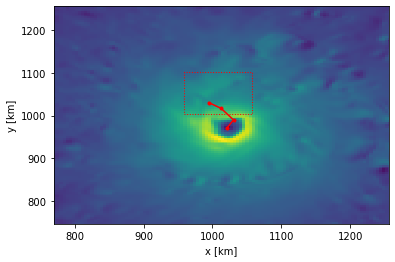

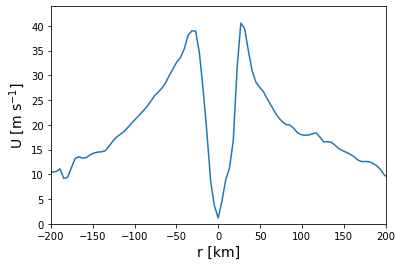

In [6]:
#%% Find hurricane center for each time
# Choose height at which the center of the hurricane is going to be defined
iz_c = 0

# Initialize array
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    # Ignore boundaries of domain
    temp_uv = np.zeros(np.shape(uv[iitt,iz_c,:,:])) + uv[iitt,iz_c,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() 
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)
    temp_x,temp_y = np.meshgrid(n_x,n_y)
    temp_x = temp_x.flatten()
    temp_y = temp_y.flatten()
    # Limits of area where to look for hurricane center
    lim_low_x = temp_x[np.argmax(uv_flat)] - 50000
    lim_low_y = temp_y[np.argmax(uv_flat)] - 50000
    lim_high_x = temp_x[np.argmax(uv_flat)] + 50000
    lim_high_y = temp_y[np.argmax(uv_flat)] + 50000
    temp_x = 0.0
    temp_y = 0.0
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)
# Free-up memory
X_grid = 0.0
Y_grid = 0.0
temp_uv = 0.0
uv_flat = 0.0
max_ws_ref = 0.0
small_x = 0.0
small_y = 0.0
flat_smallX = 0.0
flat_smallY = 0.0
temp_uv_1 = 0.0
temp_uv_2 = 0.0
temp_uv_flat = 0.0

# Visualize results for a given time
iitt = 0

# Show area considered for center of hurricane
mpyplot.figure()
mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[iitt,iz_c,:,:]) 
mpyplot.plot(center[:,0]/1000,center[:,1]/1000,'o-',color='red',markersize=3)
# mpyplot.scatter(center[iitt,0]/1000,center[iitt,1]/1000)
mpyplot.fill(np.array([lim_low_x,lim_high_x,lim_high_x,lim_low_x])/1000,np.array([lim_low_y,lim_low_y,lim_high_y,lim_high_y])/1000,facecolor='none',edgecolor='r',linestyle=':',label='Area')
mpyplot.xlabel('x [km]')
mpyplot.ylabel('y [km]')
mpyplot.xlim((min(center[:,0]) - 50*dx)/1000,(max(center[:,0]) + 50*dx)/1000)
mpyplot.ylim((min(center[:,1]) - 50*dx)/1000,(max(center[:,1]) + 50*dx)/1000)
mpyplot.show()
mpyplot.close()  


# Radial distribution of wind speed
mpyplot.figure()
r_x = (n_x - center[iitt,0])/1000
mpyplot.plot(r_x,uv[iitt,0,int(center[iitt,1]/dx),:])
mpyplot.xlim(np.min((n_x - center[iitt,0])/1000),np.max((n_x - center[iitt,0])/1000))
mpyplot.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
mpyplot.ylim(0,np.max(uv[:,iz_c,int(center[iitt,1]/dx),:]))
mpyplot.xlabel('r [km]',fontsize=14)
mpyplot.ylabel('U [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()  



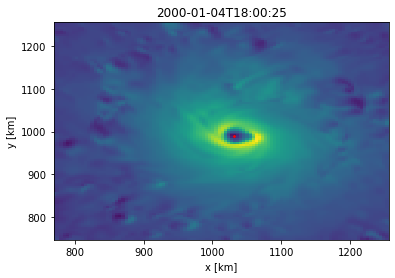

1
4


In [7]:
# Visualize results for a given time
# stop
if domain == 'd01':
    iitt = len(ttime)-3 # 21

    # Show area considered for center of hurricane
    mpyplot.figure()
    mpyplot.title(str(ttime[iitt]))
    mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[iitt,iz_c,:,:]) 
    mpyplot.scatter(center[iitt,0]/1000,center[iitt,1]/1000,color='red',s=3)
    # mpyplot.plot(center[:,0]/1000,center[:,1]/1000,'o-',color='red',markersize=3)
    # mpyplot.fill(np.array([lim_low_x,lim_high_x,lim_high_x,lim_low_x])/1000,np.array([lim_low_y,lim_low_y,lim_high_y,lim_high_y])/1000,facecolor='none',edgecolor='r',linestyle=':',label='Area')
    mpyplot.xlabel('x [km]')
    mpyplot.ylabel('y [km]')
    mpyplot.xlim((min(center[:,0]) - 50*dx)/1000,(max(center[:,0]) + 50*dx)/1000)
    mpyplot.ylim((min(center[:,1]) - 50*dx)/1000,(max(center[:,1]) + 50*dx)/1000)
    mpyplot.show()
    mpyplot.close()  
    
    print(iitt)
    print(len(ttime))


In [8]:
#%% Maximum distance from center (larger than nested domain size)
# max_dist_fromCent = (451/2+10)*(dx/3)
max_dist_fromCent = (351/2+10)*(dx/3)


In [9]:
#%% Crop all 3D fields to a shared reference frame that is centered on the center of the hurricane
# Find the maximum radial distance from the hurricane's center that is shared for all times

for it in np.arange(len(ttime)):
    # Distance from hurricane cetner to domain boundaries
    dd_x = np.min([center[it,0] - n_x[0],n_x[-1] - center[it,0]])
    dd_y = np.min([center[it,1] - n_y[0],n_y[-1] - center[it,1]])
    # Minimum distance to domain boundaries
    dd = np.min([dd_x,dd_y])
    if dd<max_dist_fromCent:
        max_dist_fromCent = dd
# Round down
temp = np.floor(max_dist_fromCent/1000)
max_dist_fromCent = temp*1000

# Initialize array
u_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
v_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
w_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
theta_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
thm_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
qv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
uv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan

for iitt in np.arange(len(ttime)):
    # Geometrical center
    geo_cent = [center[iitt,0],center[iitt,1]]
    ix_c = int(geo_cent[0]/dx)
    iy_c = int(geo_cent[1]/dx)
    # Save portion of hurricane
    if iitt==0:
        dim1 = np.shape(u_r[iitt,:,:,:])[-1]
        dim2 = np.shape(u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)])[-1]
    if dim1==dim2:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        thm_r[iitt,:,:,:] = thm[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        qv_r[iitt,:,:,:] = qv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
    else:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        thm_r[iitt,:,:,:] = thm[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        qv_r[iitt,:,:,:] = qv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    
    
# Release memory
u = 0.0
v = 0.0
w = 0.0
uv = 0.0
theta = 0.0
thm = 0.0
qv = 0.0

# # Temporal average of centered velocity fields
# mean_u_r = np.nanmean(u_r,axis=0)
# mean_v_r = np.nanmean(v_r,axis=0)
# mean_w_r = np.nanmean(w_r,axis=0)
# mean_theta_r = np.nanmean(theta_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)

# New distance arrays
n_x_r = np.arange(np.shape(mean_uv_r)[2])*dx
n_y_r = np.arange(np.shape(mean_uv_r)[1])*dx
temp_gridx,temp_gridy = np.meshgrid(n_x_r,n_y_r)
temp_uv = mean_uv_r[0,:,:].flatten()
temp_gridx = temp_gridx.flatten()
temp_gridy = temp_gridy.flatten()
n_x_r = n_x_r - temp_gridx[np.argmin(temp_uv)]
n_y_r = n_y_r - temp_gridy[np.argmin(temp_uv)]

temp_uv = 0.0
temp_gridx = 0.0
temp_gridy = 0.0

In [10]:
#%% Crop 3D fields to make them centered in a rectangle (x-y)
min_x = np.min(np.abs(np.array([n_x_r[0],n_x_r[-1]])))
min_y = np.min(np.abs(np.array([n_y_r[0],n_y_r[-1]])))

u_r = u_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
u_r = u_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

v_r = v_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
v_r = v_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

w_r = w_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
w_r = w_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

theta_r = theta_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
theta_r = theta_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

thm_r = thm_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
thm_r = thm_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

qv_r = qv_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
qv_r = qv_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

uv_r = uv_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
uv_r = uv_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

n_x_r = n_x_r[(n_x_r>-1*min_x)&(n_x_r<min_x)]
n_y_r = n_y_r[(n_y_r>-1*min_y)&(n_y_r<min_y)]

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r,axis=0)
mean_v_r = np.nanmean(v_r,axis=0)
mean_w_r = np.nanmean(w_r,axis=0)
mean_theta_r = np.nanmean(theta_r,axis=0)
mean_thm_r = np.nanmean(thm_r,axis=0)
mean_qv_r = np.nanmean(qv_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)


In [11]:
ttime

array(['2000-01-04T12:00:19', '2000-01-04T18:00:25',
       '2000-01-05T00:00:24', '2000-01-05T06:00:24'],
      dtype='datetime64[s]')

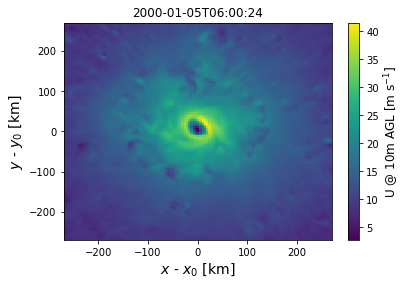

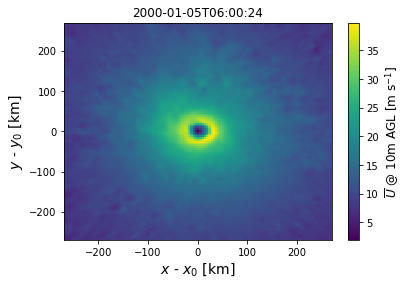

4
d01
/projects/misa5952/simulations/hurricanes/newSetup/sst_28_skipd01_skipCoLES_ndg/
3


In [12]:
# Velocity contours at one height
iz = 0
it = len(ttime)-1

mpyplot.figure()
mpyplot.title(ttime[it])
im1 = mpyplot.pcolormesh(n_x_r/1000,n_y_r/1000,uv_r[it,iz,:,:])
mpyplot.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
mpyplot.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  


mpyplot.figure()
mpyplot.title(ttime[it])
im1 = mpyplot.pcolormesh(n_x_r/1000,n_y_r/1000,np.nanmean(uv_r[:,iz,:,:],axis=0))
mpyplot.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
mpyplot.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  

print(len(ttime))
print(domain)
print(WRF_DIRECTORY)
print(it)

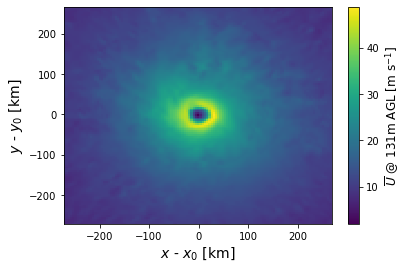

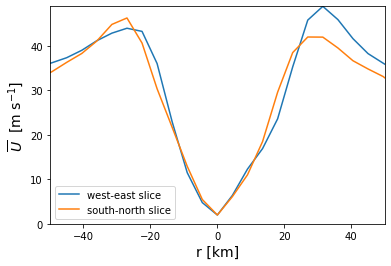

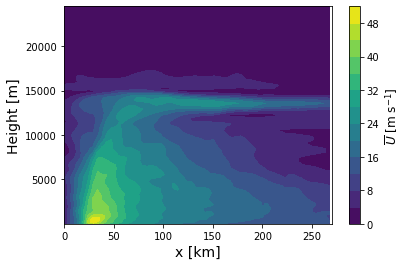

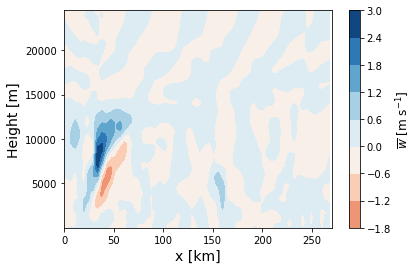

39.83071327209473
35.89819049835205


In [13]:
#%% Figures showing time-averaged velocity fields for centered hurricane

# Velocity contours at one height
iz = 5
mpyplot.figure()
# im1 = mpyplot.contourf((n_x_r-0.5*dx)/1000,(n_y_r-0.5*dx)/1000,mean_uv_r[iz,:,:],levels=15) 
im1 = mpyplot.pcolormesh((n_x_r-0.5*dx)/1000,(n_y_r-0.5*dx)/1000,mean_uv_r[iz,:,:])
mpyplot.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
mpyplot.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  

# Radial distribution of winds at one height
mpyplot.figure()
mpyplot.plot(n_x_r/1000,mean_uv_r[iz,int(0.5*len(n_y_r)),:],label='west-east slice')
mpyplot.plot(n_y_r/1000,mean_uv_r[iz,:,int(0.5*len(n_x_r))],label='south-north slice')
mpyplot.xlim(-50,50)
mpyplot.ylim(0,np.max(mean_uv_r[iz,:,:]))
mpyplot.xlabel('r [km]',fontsize=14)
mpyplot.ylabel('$\overline{U}$  [m s$^{-1}$]',fontsize=14)
mpyplot.legend()
# mpyplot.savefig(WRF_DIRECTORY + "r_hurr.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  

# Slice of velocity field
mpyplot.figure()
im1 = mpyplot.contourf((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:],levels=15) 
# im1 = mpyplot.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:])
mpyplot.xlabel('x [km]',fontsize=14)
mpyplot.ylabel('Height [m]',fontsize=14)
mpyplot.xlim(0,n_x_r[-1]/1000)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'$\overline{U}$ [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  

# Slice of vertical velocity field
mpyplot.figure()
newCmap = cmocean.tools.crop(mpyplot.cm.RdBu, np.min(mean_w_r[:,int(0.5*len(n_y_r)),:]), np.max(mean_w_r[:,int(0.5*len(n_y_r)),:]), 0)
im1 = mpyplot.contourf((n_x_r-0.5*dx)/1000,height_agl,mean_w_r[:,int(0.5*len(n_y_r)),:],cmap=newCmap) 
# im1 = mpyplot.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:])
mpyplot.xlabel('x [km]',fontsize=14)
mpyplot.ylabel('Height [m]',fontsize=14)
mpyplot.xlim(0,n_x_r[-1]/1000)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'$\overline{w}$ [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  


print(np.max(mean_uv_r[0,int(0.5*len(n_y_r)),int(0.5*len(n_x_r)):]))
print(np.max(mean_uv_r[0,int(0.5*len(n_y_r)),0:int(0.5*len(n_x_r))]))

In [14]:
#%% Time-averaged fields

tAvg_u_r = np.mean(np.array(u_r),axis=0)
tAvg_v_r = np.mean(np.array(v_r),axis=0)
tAvg_w_r = np.mean(np.array(w_r),axis=0)
tAvg_theta_r = np.mean(np.array(theta_r),axis=0)
tAvg_thm_r = np.mean(np.array(thm_r),axis=0)
tAvg_qv_r = np.mean(np.array(qv_r),axis=0)
tAvg_uv_r = np.mean(np.array(uv_r),axis=0)


In [15]:
#%% Tangential and normal velocity components

# Project velocity components from Cartesian reference frame to normal and tangential reference frame

U_t = np.zeros_like(tAvg_u_r)
U_n = np.zeros_like(tAvg_u_r)
for ix in np.arange(len(n_x_r)):
    for iy in np.arange(len(n_y_r)):
        theta_angl = np.arctan2(n_y_r[iy],n_x_r[ix])
        # t = -i sin(theta) + j cos(theta)
        U_t[:,iy,ix] = -1*tAvg_u_r[:,iy,ix]*np.sin(theta_angl) + tAvg_v_r[:,iy,ix]*np.cos(theta_angl)
        # n = - i cos(theta) -j sin(theta) 
        U_n[:,iy,ix] = -1*tAvg_u_r[:,iy,ix]*np.cos(theta_angl) - tAvg_v_r[:,iy,ix]*np.sin(theta_angl)
        
# Change from normal velocity to radial velocity
U_n = -1*U_n

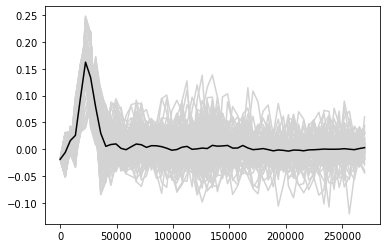

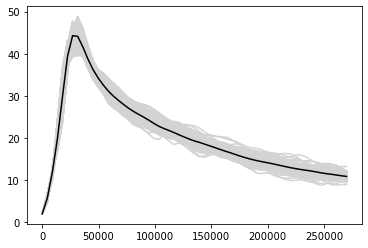

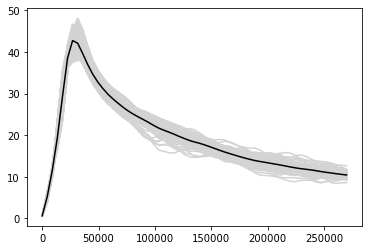

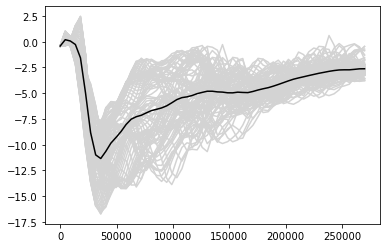

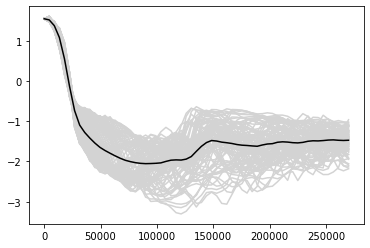

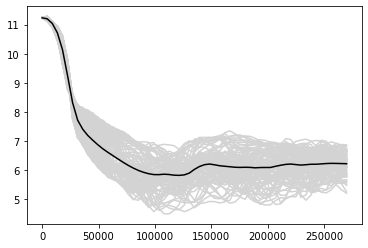

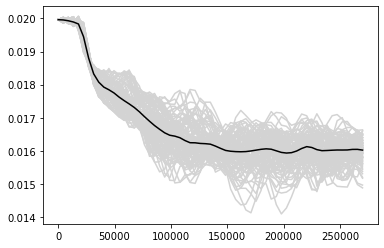

In [16]:
#%% Azimuthally and temporally averaged velocity fields

# Height for plots
izzz = 5


# Azimuthal locations
azmth = np.linspace(1,359,100)

## Radial vector
rr_ = n_x_r[n_x_r>=0]

# Vertical velocity
azmth_w_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_w_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_w_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_w_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_w_r[:,izzz,:],axis=0),'-k')

# Horizontal velocity
azmth_UV_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_uv_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_UV_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_UV_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_UV_r[:,izzz,:],axis=0),'-k')

# Tangential velocity
azmth_Ut_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_t[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_Ut_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_Ut_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_Ut_r[:,izzz,:],axis=0),'-k')

# Radial velocity
azmth_Un_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_n[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_Un_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_Un_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_Un_r[:,izzz,:],axis=0),'-k')

# Potential temperature
azmth_theta_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_theta_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_theta_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_theta_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_theta_r[:,izzz,:],axis=0),'-k')

# Moist potential temperature
azmth_thm_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_thm_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_thm_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_thm_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_thm_r[:,izzz,:],axis=0),'-k')

# Moisture
azmth_qv_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_qv_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_qv_r[ia,iz,ir] = ww[0,:]
mpyplot.figure()
for ia in np.arange(len(azmth)):
    mpyplot.plot(rr_,azmth_qv_r[ia,izzz,:],color='lightgrey')
mpyplot.plot(rr_,np.mean(azmth_qv_r[:,izzz,:],axis=0),'-k')


## Average azimuthaly
azmth_t_w_r = np.mean(azmth_w_r,axis=0)
azmth_t_UV_r = np.mean(azmth_UV_r,axis=0)
azmth_t_Ut_r = np.mean(azmth_Ut_r,axis=0)
azmth_t_Un_r = np.mean(azmth_Un_r,axis=0)
azmth_t_theta_r = np.mean(azmth_theta_r,axis=0)
azmth_t_thm_r = np.mean(azmth_thm_r,axis=0)
azmth_t_qv_r = np.mean(azmth_qv_r,axis=0)

# Vertical velocity should be zero far away from the eyewall
azmth_t_w_r = np.mean(azmth_w_r,axis=0)
azmth_t_w_r[:,rr_>0.8*np.max(rr_)] = np.round(azmth_t_w_r[:,rr_>0.8*np.max(rr_)])
# Vertical velocity should be zero near the model top
azmth_t_w_r[height_agl>20000,:] = 0

# Temperature and moisture remain constant far away from the eyewall
for iz in np.arange(len(height_agl)):
    azmth_t_theta_r[iz,rr_>0.8*np.max(rr_)] = np.mean(azmth_t_theta_r[iz,rr_>0.8*np.max(rr_)])
    azmth_t_thm_r[iz,rr_>0.8*np.max(rr_)] = np.mean(azmth_t_thm_r[iz,rr_>0.8*np.max(rr_)])
    azmth_t_qv_r[iz,rr_>0.8*np.max(rr_)] = np.mean(azmth_t_qv_r[iz,rr_>0.8*np.max(rr_)])



In [17]:
#%% Create new grid with axisymmetric fields

# Grid
ddxx = dx/3
ddzz = 5
x_grid = np.arange(-1*rr_[-1]-1,rr_[-1],ddxx)
y_grid = np.arange(-1*rr_[-1]-1,rr_[-1],ddxx)
z_grid = np.zeros_like(height_agl) + height_agl

# Initialize arrays
u_hurr = np.zeros([len(z_grid),len(y_grid),len(x_grid)])
v_hurr = np.zeros(np.shape(u_hurr))
w_hurr = np.zeros(np.shape(u_hurr))
theta_hurr = np.zeros(np.shape(u_hurr))
thm_hurr = np.zeros(np.shape(u_hurr))
qv_hurr = np.zeros(np.shape(u_hurr))

# Calculate zonal and meridional veloctity components at each location
for ix in np.arange(0,len(x_grid)):
    for iy in np.arange(0,len(y_grid)):
        # Current radial location
        r_curr = (x_grid[ix]**2 + y_grid[iy]**2)**0.5
        # Initialize arrays
        curr_uv_mag = np.zeros(len(z_grid))
#         curr_w_mag = np.zeros(len(z_grid))
#         curr_theta_mag = np.zeros(len(z_grid))
        # Interpolate fields to current point
        f_uv = scipy.interpolate.RectBivariateSpline(height_agl,rr_,azmth_t_UV_r)
        f_w = scipy.interpolate.RectBivariateSpline(height_agl,rr_,azmth_t_w_r)
        f_theta = scipy.interpolate.RectBivariateSpline(height_agl,rr_,azmth_t_theta_r)
        f_thm = scipy.interpolate.RectBivariateSpline(height_agl,rr_,azmth_t_thm_r)
        f_qv = scipy.interpolate.RectBivariateSpline(height_agl,rr_,azmth_t_qv_r)
        for iz in np.arange(len(z_grid)):
            # Horizontal velocity
            ww = f_uv(height_agl[iz],r_curr)
            curr_uv_mag[iz] = ww[0,:]
            # Vertical velocity
            ww = f_w(height_agl[iz],r_curr)
            w_hurr[iz,iy,ix] = ww[0,:]
            # Potential temperature
            ww = f_theta(height_agl[iz],r_curr)
            theta_hurr[iz,iy,ix] = ww[0,:]
            # Moist potential temperature
            ww = f_thm(height_agl[iz],r_curr)
            thm_hurr[iz,iy,ix] = ww[0,:]
            # Moisture
            ww = f_qv(height_agl[iz],r_curr)
            qv_hurr[iz,iy,ix] = ww[0,:]
         
        # Determine quadrant in cartesian coordinates
        if (x_grid[ix]>0.0001) & (y_grid[iy]>0.0001):
            # Angle to x-axis
            thet = np.arctan(y_grid[iy]/x_grid[ix])
            # Zonal velocity component
            u_hurr[:,iy,ix] = -1*curr_uv_mag*np.sin(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix]= curr_uv_mag*np.cos(thet)
        elif (x_grid[ix]<-0.0001) & (y_grid[iy]>0.0001):
            # Angle to x-axis
            thet = np.arctan(np.abs(y_grid[iy]/x_grid[ix]))
            # Zonal velocity component
            u_hurr[:,iy,ix] = -1*curr_uv_mag*np.sin(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix] = -1*curr_uv_mag*np.cos(thet)
        elif (x_grid[ix]<-0.0001) & (y_grid[iy]<-0.0001):
            # Angle to y-axis
            thet = np.arctan(np.abs(x_grid[ix]/y_grid[iy]))
            # Zonal velocity component
            u_hurr[:,iy,ix] = curr_uv_mag*np.cos(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix] = -1*curr_uv_mag*np.sin(thet)
        elif (x_grid[ix]>0.0001) & (y_grid[iy]<-0.0001):
            # Angle to y-axis
            thet = np.arctan(np.abs(y_grid[iy]/x_grid[ix]))
            # Zonal velocity component
            u_hurr[:,iy,ix] = curr_uv_mag*np.sin(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix] = curr_uv_mag*np.cos(thet)


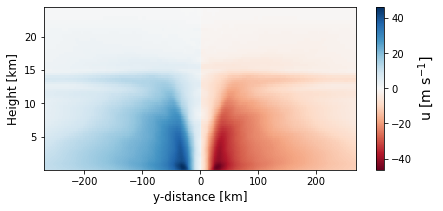

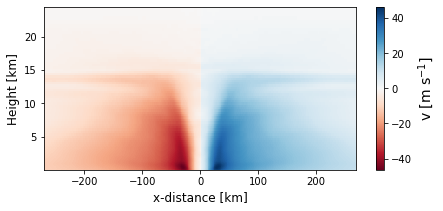

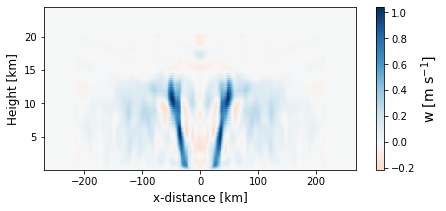

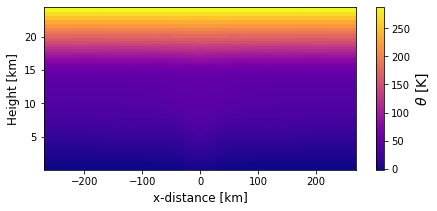

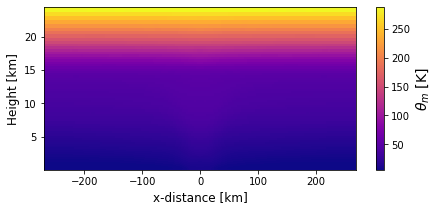

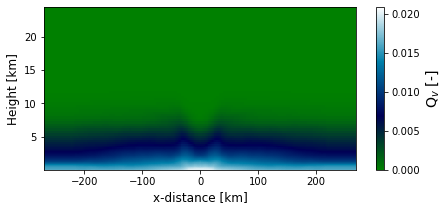

In [18]:
#%% Visualize interpolated fields

## X-Z slice
# u-velocity
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(y_grid/1000,z_grid/1000,u_hurr[:,:,int(0.5*len(x_grid))],cmap = mpyplot.cm.RdBu)
mpyplot.xlabel('y-distance [km]',fontsize=12)
mpyplot.ylabel('Height [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'u [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()
# v-velocity
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,z_grid/1000,v_hurr[:,int(0.5*len(y_grid)),:],cmap = mpyplot.cm.RdBu)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('Height [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'v [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()
# w-velocity
mpyplot.figure(figsize=(7,3))
newCmap = cmocean.tools.crop(mpyplot.cm.RdBu, np.min(w_hurr[:,int(0.5*len(y_grid)),:]), np.max(w_hurr[:,int(0.5*len(y_grid)),:]), 0)
mpyplot.pcolormesh(x_grid/1000,z_grid/1000,w_hurr[:,int(0.5*len(y_grid)),:],cmap = newCmap)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('Height [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'w [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()
# theta
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,z_grid/1000,theta_hurr[:,int(0.5*len(y_grid)),:],cmap = mpyplot.cm.plasma)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('Height [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'$\theta$ [K]',fontsize=14)
mpyplot.show()
mpyplot.close()
# theta-moist
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,z_grid/1000,thm_hurr[:,int(0.5*len(y_grid)),:],cmap = mpyplot.cm.plasma)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('Height [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'$\theta_m$ [K]',fontsize=14)
mpyplot.show()
mpyplot.close()
# Moisture
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,z_grid/1000,qv_hurr[:,int(0.5*len(y_grid)),:],cmap = mpyplot.cm.ocean)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('Height [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'Q$_v$ [-]',fontsize=14)
mpyplot.show()
mpyplot.close()


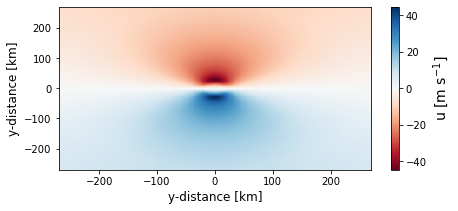

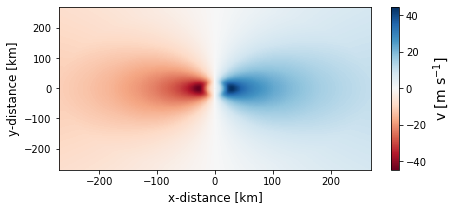

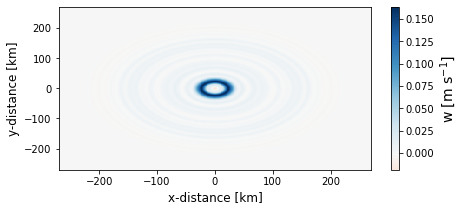

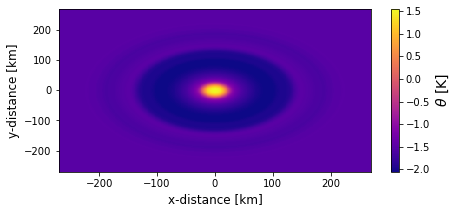

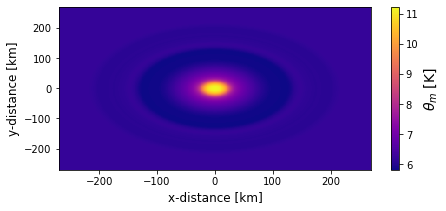

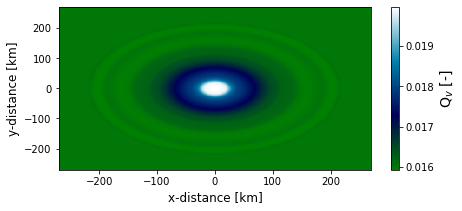

In [19]:
#%% Visualize interpolated fields

iz = 5

## X-Y slice
# u-velocity
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,y_grid/1000,u_hurr[iz,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.xlabel('y-distance [km]',fontsize=12)
mpyplot.ylabel('y-distance [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'u [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()
# v-velocity
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,y_grid/1000,v_hurr[iz,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('y-distance [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'v [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()
# w-velocity
mpyplot.figure(figsize=(7,3))
newCmap = cmocean.tools.crop(mpyplot.cm.RdBu, np.min(w_hurr[iz,:,:]), np.max(w_hurr[iz,:,:]), 0)
mpyplot.pcolormesh(x_grid/1000,y_grid/1000,w_hurr[iz,:,:],cmap = newCmap)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('y-distance [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'w [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()
# theta
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,y_grid/1000,theta_hurr[iz,:,:],cmap = mpyplot.cm.plasma)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('y-distance [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'$\theta$ [K]',fontsize=14)
mpyplot.show()
mpyplot.close()
# theta-moist
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,y_grid/1000,thm_hurr[iz,:,:],cmap = mpyplot.cm.plasma)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('y-distance [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'$\theta_m$ [K]',fontsize=14)
mpyplot.show()
mpyplot.close()
# Moisture
mpyplot.figure(figsize=(7,3))
mpyplot.pcolormesh(x_grid/1000,y_grid/1000,qv_hurr[iz,:,:],cmap = mpyplot.cm.ocean)
mpyplot.xlabel('x-distance [km]',fontsize=12)
mpyplot.ylabel('y-distance [km]',fontsize=12)
cbar = mpyplot.colorbar()
cbar.set_label(r'Q$_v$ [-]',fontsize=14)
mpyplot.show()
mpyplot.close()


In [20]:
stop

NameError: name 'stop' is not defined

## Modify restart file for dx=1.5km

In [21]:
#%% Define file names for restart files
# input_largeDomain = "wrfrst_d01_2000-01-05_00:00:23_init" #"wrfrst_d02_2000-01-05_00:00:13_input"
# modified_input = "wrfrst_d01_2000-01-05_00:00:23_mod" #"wrfrst_d02_2000-01-05_00:00:13_mod"
# WRF_DIRECTORY_ndg = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"




WRF_DIRECTORY_ndg = "/projects/misa5952/simulations/hurricanes/newSetup/sst_30_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY_ndg = "/projects/misa5952/simulations/hurricanes/newSetup/sst_28_skipd01_skipCoLES_ndg/"

input_largeDomain = "wrfrst_d01_2000-01-05_00:00:23_init" 
modified_input = "wrfrst_d01_2000-01-05_00:00:23_mod" 

In [22]:
#%% Extract variables from input of large domain
ds=xr.open_dataset(WRF_DIRECTORY_ndg+input_largeDomain,decode_times=False)
# Wind speed
u_rst = ds['U_1']
# u_np = np.array(u_rst[:,:,:,:])
v_rst = ds['V_1']
# v_np = np.array(v_rst[:,:,:,:])
w_rst = ds['W_1']
# w_np = np.array(w_rst[:,:,:,:])
thm_rst = ds['THM_1']
# thm_np = np.array(thm_rst[:,:,:,:])
t_rst = ds['T']
# t_np = np.array(t_rst[:,:,:,:])
qv_rst = ds['QVAPOR']
# qv_np = np.array(qv_rst[:,:,:,:])
# Base-state variables
base_t_rst = np.array(ds['T_BASE'])
base_qv_rst = np.array(ds['QV_BASE'])
# Make sure initial profiles have not been calculated yet
init_prof_rst = ds['INITIAL_PROF']
# Sea surface temperautre
sst = ds['TSK']
# Land or sea mask
xland = ds['XLAND']
# Coriolis terms
coriolis_cos = ds['E']
coriolis_sin = ds['F']
# Height variables
ph = ds['PH_1']
ph = np.array(ph[0,:,:,:])
phb = ds['PHB']
phb = np.array(phb[0,:,:,:])
height_stag = (ph+phb)/9.81
ph = 0.0
phb = 0.0
hgt_rst = (height_stag[1:,:,:]+height_stag[0:-1,:,:])/2
hgt_rst = np.array(np.mean(np.mean(hgt_rst,axis=1),axis=1))
height_stag = np.mean(np.mean(height_stag,axis=1),axis=1)
# Domain dimensions
dx_nest = ds.DX
ds.close()
ds = 0.0

print("done extracting variables for input simulation")


done extracting variables for input simulation


In [23]:
#%% Modify Coriolis, land/sea mask, and surface temperature
# Coriolis parameter for f-plane
lat = 20
Omega = 7.2921*(10**-5) # rad/s
f = 2*Omega*np.sin(lat*np.pi/180) # 1/s


# Sea surface temperature
SST_hurr = 28 + 273.15
sst[:,:,:] = SST_hurr

print('SST is %f deg C' % (SST_hurr - 273.15))

# Change from Land to Sea so that iscflx = 1 works
xland[:,:,:] = 2

# Set Coriolis in simulations
coriolis_cos[:,:,:] = 2*Omega*np.cos(lat*2*np.pi/360)
coriolis_sin[:,:,:] = 2*Omega*np.sin(lat*2*np.pi/360)

SST is 28.000000 deg C


In [24]:
#%% Interpolate from axisymmetic hurricane grid to WRF grid
# Find center of domain
ix_mid = int(0.5*(np.shape(u_hurr)[2]-1))
iy_mid = int(0.5*(np.shape(u_hurr)[1]-1))
L_yy = int(0.5*np.shape(u_rst)[2])
L_xx = int(0.5*np.shape(u_rst)[3])

# RE-WRITE velocity field for each vertical level
for iz in np.arange(len(hgt_rst)):
    # Find closest vertical level
    i_close = np.argmin(np.abs(height_agl - hgt_rst[iz]))
    if i_close==len(height_agl)-1:
        i_close = i_close-1
    a = np.abs(height_agl[i_close]-hgt_rst[iz])/(height_agl[i_close+1] - height_agl[i_close])
    b = 1-a
    
    if 'sst_26' in WRF_DIRECTORY_ndg:
        # Re-write zonal velocity field
        u_rst[0,iz,:,:] = b*u_hurr[i_close,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx-1:ix_mid+L_xx] + a*u_hurr[i_close+1,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx-1:ix_mid+L_xx]

        # Re-write meridional velocity field
        v_rst[0,iz,:,:] = b*v_hurr[i_close,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] + a*v_hurr[i_close+1,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx]

        # Re-write vertical velocity field
        w_rst[0,iz,:,:] = b*w_hurr[i_close,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] + a*w_hurr[i_close+1,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx]

        # Re-write potential temperature field
        t_rst[0,iz,:,:] = b*theta_hurr[i_close,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] + a*theta_hurr[i_close+1,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx]

        # Re-write moist potential temperature field
        thm_rst[0,iz,:,:] = b*thm_hurr[i_close,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] + a*thm_hurr[i_close+1,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx]

        # Re-write moisture field
        qv_rst[0,iz,:,:] = b*qv_hurr[i_close,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] + a*qv_hurr[i_close+1,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx]
    
    else:
        # Re-write zonal velocity field
        u_rst[0,iz,:,:] = b*u_hurr[i_close,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] + a*u_hurr[i_close+1,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx]

        # Re-write meridional velocity field
        v_rst[0,iz,:,:] = b*v_hurr[i_close,iy_mid-L_yy-2:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx] + a*v_hurr[i_close+1,iy_mid-L_yy-2:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx]

        # Re-write vertical velocity field
        w_rst[0,iz,:,:] = b*w_hurr[i_close,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx] + a*w_hurr[i_close+1,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx]

        # Re-write potential temperature field
        t_rst[0,iz,:,:] = b*theta_hurr[i_close,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx] + a*theta_hurr[i_close+1,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx]

        # Re-write moist potential temperature field
        thm_rst[0,iz,:,:] = b*thm_hurr[i_close,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx] + a*thm_hurr[i_close+1,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx]

        # Re-write moisture field
        qv_rst[0,iz,:,:] = b*qv_hurr[i_close,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx] + a*qv_hurr[i_close+1,iy_mid-L_yy-1:iy_mid+L_yy,ix_mid-L_xx+1:ix_mid+L_xx]

    
# Make sure initial inflow profiles have not been calculated
init_prof_rst[:] = 0
print(init_prof_rst)

<xarray.DataArray 'INITIAL_PROF' (Time: 1)>
array([0], dtype=int32)
Coordinates:
    XTIME    (Time) float32 ...
Dimensions without coordinates: Time
Attributes:
    FieldType:    106
    MemoryOrder:  0  
    description:  
    units:        
    stagger:      


In [25]:
np.shape(u_rst)

(1, 108, 321, 322)

In [26]:
# Clear memory
u_hurr = 0.0
v_hurr = 0.0
w_hurr = 0.0
theta_hurr = 0.0
thm_hurr = 0.0
qv_hurr = 0.0

In [27]:
#%% Rewrite restart file using extrapolated fields
ds=xr.open_dataset(WRF_DIRECTORY_ndg+input_largeDomain)
# Re-write zonal winds
ds = ds.drop_vars('U_1')
ds = ds.assign(U_1=u_rst)
ds = ds.drop_vars('U_2')
ds = ds.assign(U_2=u_rst)
# Re-write meridional winds
ds = ds.drop_vars('V_1')
ds = ds.assign(V_1=v_rst)
ds = ds.drop_vars('V_2')
ds = ds.assign(V_2=v_rst)
# Re-write vertical winds
ds = ds.drop_vars('W_1')
ds = ds.assign(W_1=w_rst)
ds = ds.drop_vars('W_2')
ds = ds.assign(W_2=w_rst)
# Re-write potential temperature
ds = ds.drop_vars('T')
ds = ds.assign(T=t_rst)
# Re-write moist potential temperature
ds = ds.drop_vars('THM_1')
ds = ds.assign(THM_1=thm_rst)
ds = ds.drop_vars('THM_2')
ds = ds.assign(THM_2=thm_rst)
# Re-write moisture
ds = ds.drop_vars('QVAPOR')
ds = ds.assign(QVAPOR=qv_rst)
# Re-write intitial inflow profile flag
ds = ds.drop_vars('INITIAL_PROF')
ds = ds.assign(INITIAL_PROF=init_prof_rst)
# Re-write sea surface temperature
ds = ds.drop_vars('TSK')
ds = ds.assign(TSK=sst)
# Re-write land sea mask
ds = ds.drop_vars('XLAND')
ds = ds.assign(XLAND=xland)
# Re-write Coriolis terms
ds = ds.drop_vars('E')
ds = ds.assign(E=coriolis_cos)
ds = ds.drop_vars('F')
ds = ds.assign(F=coriolis_sin)
# Re-write file
ds.to_netcdf(WRF_DIRECTORY_ndg+modified_input)
ds.close()

In [28]:
#%% Verify the fields are modified
# Extract variables from initial input file
ds=xr.open_dataset(WRF_DIRECTORY_ndg+input_largeDomain)
u_init = ds['U_2']
v_init = ds['V_2']
w_init = ds['W_2']
t_init = ds['T']
thm_init = ds['THM_2']
qv_init = ds['QVAPOR']
sst_init = ds['TSK']
xland_init = ds['XLAND']
CO_init = ds['F']
ds.close()
ds = 0

# Extract variables from modified input file
ds=xr.open_dataset(WRF_DIRECTORY_ndg+modified_input)
u_mod = ds['U_1']
v_mod = ds['V_1']
w_mod = ds['W_1']
t_mod = ds['T']
thm_mod = ds['THM_1']
qv_mod = ds['QVAPOR']
initProf_mod = ds['INITIAL_PROF']
sst_mod = ds['TSK']
xland_mod = ds['XLAND']
CO_mod = ds['F']
ds.close()
ds = 0

print(initProf_mod)

<xarray.DataArray 'INITIAL_PROF' (Time: 1)>
array([0], dtype=int32)
Coordinates:
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time
Attributes:
    FieldType:    106
    MemoryOrder:  0  
    description:  
    units:        
    stagger:      


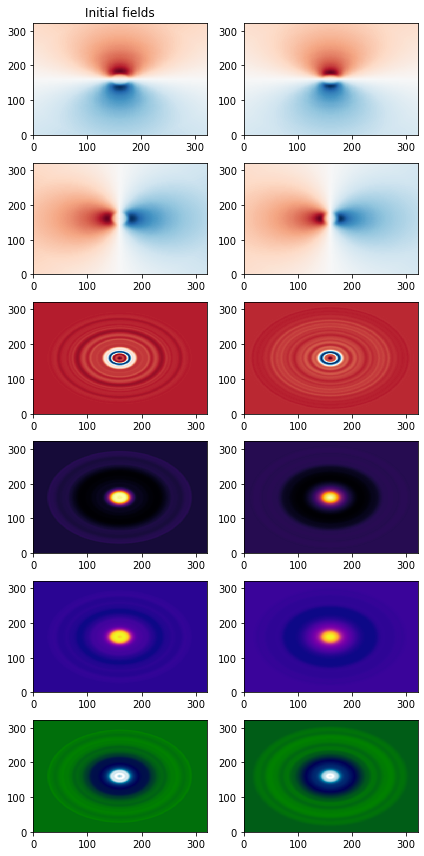

In [29]:
#%% Visualize initial and modified fields
# Figures
mpyplot.figure(figsize=(6,12))
# Initial files
mpyplot.subplot(6,2,1)
mpyplot.title('Initial fields',x=0.5,y=1.01)
mpyplot.pcolormesh(u_init[0,13,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,3)
mpyplot.pcolormesh(v_init[0,13,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,5)
mpyplot.pcolormesh(w_init[0,13,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,7)
mpyplot.pcolormesh(t_init[0,13,:,:],cmap = mpyplot.cm.inferno)
mpyplot.subplot(6,2,9)
mpyplot.pcolormesh(thm_init[0,13,:,:],cmap = mpyplot.cm.plasma)
mpyplot.subplot(6,2,11)
mpyplot.pcolormesh(qv_init[0,13,:,:],cmap = mpyplot.cm.ocean)
# Modified files
mpyplot.subplot(6,2,2)
mpyplot.pcolormesh(u_mod[0,13,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,4)
mpyplot.pcolormesh(v_mod[0,13,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,6)
mpyplot.pcolormesh(w_mod[0,13,:,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,8)
mpyplot.pcolormesh(t_mod[0,13,:,:],cmap = mpyplot.cm.inferno)
mpyplot.subplot(6,2,10)
mpyplot.pcolormesh(thm_mod[0,13,:,:],cmap = mpyplot.cm.plasma)
mpyplot.subplot(6,2,12)
mpyplot.pcolormesh(qv_mod[0,13,:,:],cmap = mpyplot.cm.ocean)

mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()

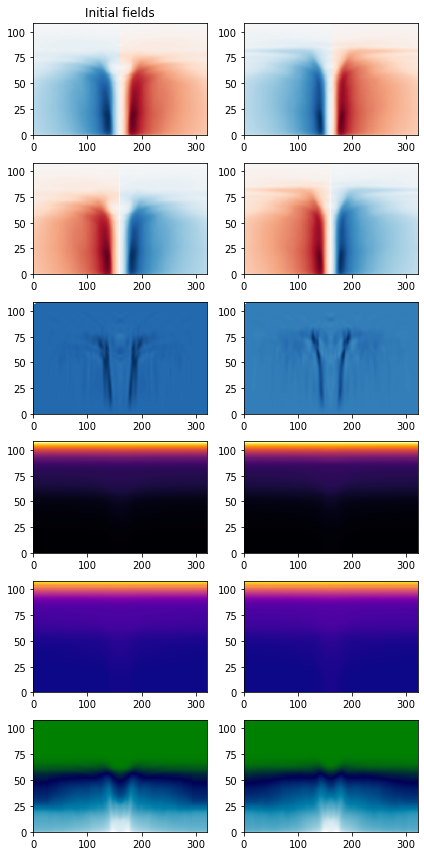

In [30]:
#%% Visualize initial and modified fields

cent = int(0.5*np.shape(u_init)[-1])

# Figures
mpyplot.figure(figsize=(6,12))
# Initial files
mpyplot.subplot(6,2,1)
mpyplot.title('Initial fields',x=0.5,y=1.01)
mpyplot.pcolormesh(u_init[0,:,:,cent],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,3)
mpyplot.pcolormesh(v_init[0,:,cent,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,5)
mpyplot.pcolormesh(w_init[0,:,:,cent],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,7)
mpyplot.pcolormesh(t_init[0,:,:,cent],cmap = mpyplot.cm.inferno)
mpyplot.subplot(6,2,9)
mpyplot.pcolormesh(thm_init[0,:,:,cent],cmap = mpyplot.cm.plasma)
mpyplot.subplot(6,2,11)
mpyplot.pcolormesh(qv_init[0,:,:,cent],cmap = mpyplot.cm.ocean)
# Modified files
mpyplot.subplot(6,2,2)
mpyplot.pcolormesh(u_mod[0,:,:,cent],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,4)
mpyplot.pcolormesh(v_mod[0,:,cent,:],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,6)
mpyplot.pcolormesh(w_mod[0,:,:,cent],cmap = mpyplot.cm.RdBu)
mpyplot.subplot(6,2,8)
mpyplot.pcolormesh(t_mod[0,:,:,cent],cmap = mpyplot.cm.inferno)
mpyplot.subplot(6,2,10)
mpyplot.pcolormesh(thm_mod[0,:,:,cent],cmap = mpyplot.cm.plasma)
mpyplot.subplot(6,2,12)
mpyplot.pcolormesh(qv_mod[0,:,:,cent],cmap = mpyplot.cm.ocean)

mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()

In [31]:
print("SST init = %f C; SST mod = %f C" % (np.median(sst_init),np.median(sst_mod)))
print("XLAND init = %f ; XLAND mod = %f " % (np.median(xland_init),np.median(xland_mod)))
print("Latitude for Coriolis terms was %f deg and now is %f deg" % 
      (np.arcsin(np.min(CO_init)/(2*Omega))*180/np.pi,np.arcsin(np.min(CO_mod)/(2*Omega))*180/np.pi))

SST init = 299.149994 C; SST mod = 301.149994 C
XLAND init = 2.000000 ; XLAND mod = 2.000000 
Latitude for Coriolis terms was 20.000000 deg and now is 20.000000 deg
